## **Step 1 - keywords Extraction**
***

general overview of the work done :

0. obtain a dataset of dreams descriptions.  
1. scrape dream symbols from dreammoods.com   
2. split them into symbol, context and meaning  
3. for each dream in the dreams dataset match 5 best fitting contexts from symbols dataset  
4. construct input promt for the model: for each dream attach the 5 found contexts, with their symbol and interpretation.  
5. take the longest input as a sample input and measure the maximum batch size that the given machine can handle  
6. run the inputs through the model  
7. run evaluations: compare the results vs. the dream description    

We have two datasets, one with dream text descriptions:

In [5]:
test_run = True
rows_limit = slice(0,1000)
# Note: slice(None) is like arr[:]

output_root = "output/run_may_15"

In [2]:
from keyword_extractor import read_datasets, extract_and_save_keywords_from_dataframes
from yaml_parser import load_config
config = load_config()
dream_df, keywords_df = read_datasets(config)
dream_df.head()

,dream_id,text_dream,context
0,1,"The one at the Meads's house, where it's bigge...",To dream that you are inside a stranger's hous...
1,2,I'm at a family reunion in a large fine house ...,Dreaming that you are going down a hill;To see...
2,3,I watch a plane fly past and shortly realize i...,To dream that you are having difficulties cont...
3,4,Me pulling the green leaves and berries off so...,Dreaming that you are breaking into someone's ...
4,5,I'm in a room that reminds me of (but definite...,To dream that you are in a dining room;To drea...


The only column we need is text_dream. And dream_id for identification. So we can drop the rest.  

In [3]:
dream_df = dream_df[["dream_id","text_dream","context"]]

And another one with interpretations of dreams according to keywords:

In [4]:

keywords_df.loc[keywords_df.context.isna(),"context"] = keywords_df.loc[keywords_df.context.isna(),"symbol"]
keywords_df["context_len"] = keywords_df.context.str.len()
keywords_df

,symbol,context,meaning,context_len,n_meanings
0,T,To see the letter T in your dream,represents your stubbornness and your refusal...,33,1
1,Table,To see a table in your dream,represents social unity and family connection...,28,6
2,Table,To dream that you are setting the table,suggests that you laying the groundwork for a...,39,6
3,Table,To see a round table in your dream,"indicates evenness, sharing, cooperation, equ...",34,6
4,Table,To dream that you are lying on a table,indicates your need for nourishment and relax...,38,6
...,...,...,...,...,...
7793,Lute,To see or play the lute in your dream,symbolizes pureness and faith.,37,1
7794,Luxury,To dream that you are living in luxury,represents your lavish lifestyle. The dream m...,38,1
7795,Lying,#Ref:liar,#Ref:liar,9,1
7796,Lynching,To see a lynching in your dream,represents feelings of self-guilt.,31,1


In [5]:
# for now, let's drop the #Ref synonyms
keywords_df = keywords_df[~keywords_df.context.str.contains("#Ref")]

In [6]:
keywords_df

,symbol,context,meaning,context_len,n_meanings
0,T,To see the letter T in your dream,represents your stubbornness and your refusal...,33,1
1,Table,To see a table in your dream,represents social unity and family connection...,28,6
2,Table,To dream that you are setting the table,suggests that you laying the groundwork for a...,39,6
3,Table,To see a round table in your dream,"indicates evenness, sharing, cooperation, equ...",34,6
4,Table,To dream that you are lying on a table,indicates your need for nourishment and relax...,38,6
...,...,...,...,...,...
7792,Lust,To dream that someone is lusting after you,means that you think highly of yourself. You ...,42,2
7793,Lute,To see or play the lute in your dream,symbolizes pureness and faith.,37,1
7794,Luxury,To dream that you are living in luxury,represents your lavish lifestyle. The dream m...,38,1
7796,Lynching,To see a lynching in your dream,represents feelings of self-guilt.,31,1


Then, we used a pretrained Sentence transformer to encode the dream embeddings and keyword embeddings and try to extract the most significant keywords from each dream.

### **all-MiniLM-L6-v2**
***

In [7]:
dream_df = extract_and_save_keywords_from_dataframes(dream_df, keywords_df)
dream_df

,dream_id,text_dream,context
0,1,"The one at the Meads's house, where it's bigge...",To dream that you are inside a stranger's hous...
1,2,I'm at a family reunion in a large fine house ...,Dreaming that you are going down a hill;To see...
2,3,I watch a plane fly past and shortly realize i...,To dream that you are having difficulties cont...
3,4,Me pulling the green leaves and berries off so...,Dreaming that you are breaking into someone's ...
4,5,I'm in a room that reminds me of (but definite...,To dream that you are in a dining room;To drea...
...,...,...,...
20995,33062,The dream was about me and my boyfriend going ...,To dream that you fall off a mountain;To dream...
20996,33063,Two weeks ago this guy asked me to Senior Ball...,To dream that you are fishing;To dream that yo...
20997,33064,My boyfriend just broke up with me so he was o...,To dream about a girl that you just met;To dre...
20998,33065,I was in my backyard and I was flying. I would...,To dream that you are soaring through the air;...


To view the dataframe better, We will filter out the interesting columns:

In [8]:
columns_to_show = ['dream_id','text_dream', 'context']
dream_df[columns_to_show]

,dream_id,text_dream,context
0,1,"The one at the Meads's house, where it's bigge...",To dream that you are inside a stranger's hous...
1,2,I'm at a family reunion in a large fine house ...,Dreaming that you are going down a hill;To see...
2,3,I watch a plane fly past and shortly realize i...,To dream that you are having difficulties cont...
3,4,Me pulling the green leaves and berries off so...,Dreaming that you are breaking into someone's ...
4,5,I'm in a room that reminds me of (but definite...,To dream that you are in a dining room;To drea...
...,...,...,...
20995,33062,The dream was about me and my boyfriend going ...,To dream that you fall off a mountain;To dream...
20996,33063,Two weeks ago this guy asked me to Senior Ball...,To dream that you are fishing;To dream that yo...
20997,33064,My boyfriend just broke up with me so he was o...,To dream about a girl that you just met;To dre...
20998,33065,I was in my backyard and I was flying. I would...,To dream that you are soaring through the air;...


In [9]:
from utils import save_df_as_pretty_html
save_df_as_pretty_html(dream_df[columns_to_show][:2000],  "html/dreams_with_context.html")
dream_df[columns_to_show].to_csv("datasets/dreams_with_context.csv", index=False)

✅ HTML table saved to: html/dreams_with_context.html


In [10]:
dream_df


,dream_id,text_dream,context
0,1,"The one at the Meads's house, where it's bigge...",To dream that you are inside a stranger's hous...
1,2,I'm at a family reunion in a large fine house ...,Dreaming that you are going down a hill;To see...
2,3,I watch a plane fly past and shortly realize i...,To dream that you are having difficulties cont...
3,4,Me pulling the green leaves and berries off so...,Dreaming that you are breaking into someone's ...
4,5,I'm in a room that reminds me of (but definite...,To dream that you are in a dining room;To drea...
...,...,...,...
20995,33062,The dream was about me and my boyfriend going ...,To dream that you fall off a mountain;To dream...
20996,33063,Two weeks ago this guy asked me to Senior Ball...,To dream that you are fishing;To dream that yo...
20997,33064,My boyfriend just broke up with me so he was o...,To dream about a girl that you just met;To dre...
20998,33065,I was in my backyard and I was flying. I would...,To dream that you are soaring through the air;...


## Step 2 - Summarize interpretations

After extracting the meaningful keywords, we tried to fetch the matching interpretation for each extracted keyword and use a pretrained LLM to summarize these interpretations into one interpretation.

### Load data and prepare (small) dataset for experimenting

In [2]:
import pandas as pd
import pandasql as ps
from plotly import express as px
from datetime import datetime
from transformers import pipeline
from utils import  release_all_gpu_memory, save_df_as_pretty_html
from summarizer import load_causal_model, batch_generate_interpretations
from summarizer import format_input, attach_meanings, PromptFormatter
import torch


In [12]:
dream_df = attach_meanings(dream_df, keywords_df)

In [13]:
dream_df

,dream_id,text_dream,context,meanings
0,1,"The one at the Meads's house, where it's bigge...",To dream that you are inside a stranger's hous...,- Trick or Treating: To dream that trick or t...
1,2,I'm at a family reunion in a large fine house ...,Dreaming that you are going down a hill;To see...,- Fainting: To dream that you are fainting su...
2,3,I watch a plane fly past and shortly realize i...,To dream that you are having difficulties cont...,- Family: Dreaming that a serial killer is ki...
3,4,Me pulling the green leaves and berries off so...,Dreaming that you are breaking into someone's ...,- Trick or Treating: To dream that trick or t...
4,5,I'm in a room that reminds me of (but definite...,To dream that you are in a dining room;To drea...,- Dining Room: To dream that you are in a din...
...,...,...,...,...
20995,33062,The dream was about me and my boyfriend going ...,To dream that you fall off a mountain;To dream...,- Fall: To dream that you fall and are not fr...
20996,33063,Two weeks ago this guy asked me to Senior Ball...,To dream that you are fishing;To dream that yo...,- Trout: To see a trout in your dream symboli...
20997,33064,My boyfriend just broke up with me so he was o...,To dream about a girl that you just met;To dre...,- Boy: If you are female and dream that you s...
20998,33065,I was in my backyard and I was flying. I would...,To dream that you are soaring through the air;...,- Trampoline: To dream that you are jumping o...


In [14]:
save_df_as_pretty_html(dream_df[:1000],"html/dreams_with_context_and_meanings.html")

✅ HTML table saved to: html/dreams_with_context_and_meanings.html


In [15]:
dream_df.to_csv("datasets/dreams_with_context_and_meanings.csv", index=False)


Now, we will create a prompt for the LLM. The prompt will include a request for the LLM to summarize the interpretations. It will get the dream description, the keywords, and the interpretations.

### Summarize with flan-T5-large model

In [16]:
release_all_gpu_memory()

['model', 'tokenizer', 'text2text_generator']
clearing cuda cache
clearing ipc cache
✅ All GPU memory cleared.


In [17]:
# Use this cell to re-import a function in case you've updated it's code in summarizer.py
from importlib import reload
import summarizer
reload(summarizer)

# Now re-import manually
from summarizer import *


In [18]:
# Step 1: Load FLAN-T5 model and tokenizer
model_name = "google/flan-t5-large"
model_family="encoder"
prompt = "Interpret this dream: "

model_name_short = model_name.split("/")[-1]
device = 0 if torch.cuda.is_available() else -1
model, tokenizer = load_causal_model(model_name)
formatter = PromptFormatter(model_family)

dataset = format_input(dream_df, prompt, formatter, tokenizer)

formatting input


In [19]:
#dataset = pd.read_csv("datasets/dreams_with_context_and_meanings.csv")

In [20]:
dataset

,dream_id,text_dream,context,meanings,input,len,input_tokens_len,hash
7235,8655,I had bought Grandma F's house to save it from...,To fix an appliance in your dream;To see a bak...,- Bake-house: To see a bake-house in your dre...,Interpret this dream: I had bought Grandma F's...,24057,5730,2d83c327596748dd92cec8e77ce640d2
6646,7939,I was working for SVH. I had two sons. One was...,To dream of sibling rivalry;Ditch;To dream tha...,- Father: To dream that your father is angry ...,Interpret this dream: I was working for SVH. I...,14012,3327,73a02160761b3a2367e43c9afc05aa1a
7439,8900,Matthew and I are at Kings Island. We hadn't g...,To dream that the rides at the amusement park ...,- Carnival: To dream that you are on a carniv...,Interpret this dream: Matthew and I are at Kin...,14108,3285,d2765ccb296f4e5c09b30b4845267dc7
15873,20270,The dream started off in sort of an ancient Gr...,To dream that you are in a maze;To dream that ...,- Tomb: To dream that you are trapped in a to...,Interpret this dream: The dream started off in...,12307,3011,326eea1500a6caaf4a66ebedcc486957
6602,7885,I was the housekeeper for a man and his young ...,To dream that you have a husband (but you do n...,- Child: To dream that you lose a child repre...,Interpret this dream: I was the housekeeper fo...,13076,3007,1eafdb46fa4b8c6171b9aa07a2a2bc44
...,...,...,...,...,...,...,...,...
9441,12148,I went to the movies and took my favourite jum...,To see or wear a life jacket in your dream;To ...,- Chicken Suit: To dream that you are wearing...,Interpret this dream: I went to the movies and...,990,232,033dd3f126dab1121f8d6cf874d2c2fb
13878,17762,Shopping With Jane Rock I am at the Quaint Bo...,Fishing;To dream that you got something at a c...,- Fish Market: To dream that you go to a fish...,Interpret this dream: Shopping With Jane Rock ...,989,231,fe8bad2a833855345b03cc99adb42df0
20920,32983,I was lying down in my bed and my mom was on t...,To dream that you are possessed by demons;To h...,- Ghost: To dream that you turn into a ghost ...,Interpret this dream: I was lying down in my b...,905,223,34b9834d19b986162d5c30c0377b773e
6041,7096,What can I do with this heavy pack of old maga...,Dreaming about a gun magazine;To open a gift a...,- Bag: To dream of a bag full of junk symboli...,Interpret this dream: What can I do with this ...,859,213,094bbd56f16e75fa7212f04e5bb3e145


In [21]:
# filter dataset only to inputs of size that we can handle
dataset = dataset[dataset["input_tokens_len"] <500]

In [22]:
dataset = dataset[rows_limit]

In [23]:
dataset

,dream_id,text_dream,context,meanings,input,len,input_tokens_len,hash
20042,25908,I was standing in an open field or perhaps a l...,To see the landing of an aircraft in your drea...,- Reflection: If you see a strange figure or ...,Interpret this dream: I was standing in an ope...,2151,499,2e880f6f2490198cfae0d1905eca82cc
8335,10276,Pedro and BOB and others and I are walking for...,To dream that you are in a restaurant;If you d...,- Telephone Booth: Dreaming that the the phon...,Interpret this dream: Pedro and BOB and others...,2223,499,6ec92bc7e5ad2fb193d3ed754e4d3020
18202,23664,I was washing in a bathroom at what in the dre...,Dreaming that someone defecated on your bed;To...,- Bathtubs: To dream that you or someone has ...,Interpret this dream: I was washing in a bathr...,2044,499,fd23c2cb9bf5d2ab78e0735f8d03d8a2
1657,1935,Bonnie and I are homeless. We have learned tho...,To dream that you are homeless;Seeing someone ...,- Garage: To dream that there is a homeless f...,Interpret this dream: Bonnie and I are homeles...,2202,499,83d1891153c8b769cfc9d9b511a18e73
13435,17260,Cheryl's House I'm in a van with my friend Ch...,To see an oak tree at the fork in the road;To ...,- Tree House: To see or dream that you are in...,Interpret this dream: Cheryl's House I'm in a...,1939,499,de3bb5a3bd915fd80cff9c2c6be0c251
...,...,...,...,...,...,...,...,...
17675,23130,I dreamed that for some reason I was confined ...,Dreaming that you are burying the bones of som...,- Bones: Dreaming that you are burying the bo...,Interpret this dream: I dreamed that for some ...,2086,479,08901d8daec750fc19a9c09d3ec39469
10472,13965,"Mom, Ezra and I went through the drive thru at...",Dreaming about your friend's mother;To dream t...,- Funeral: To dream that you are attending a ...,"Interpret this dream: Mom, Ezra and I went thr...",1987,479,b73505580c81cdec62c18c71fc06ee23
1199,1347,I'm at Mabel's house. They have offered to let...,To dream that you are at a ranch;To dream that...,- Farmer's Market: To dream that you are at a...,Interpret this dream: I'm at Mabel's house. Th...,1883,479,eaa5d5a4086c5c911c8257819b488b33
4843,5509,I had this dream that Mrs. Carter and I were s...,Dreaming of horrific things;To dream that you ...,- Fingernails: To dream that you broke a fing...,Interpret this dream: I had this dream that Mr...,2114,479,95122e8c58faed594d21f3f35d8d1f06


In [24]:
text2text_generator = pipeline(
        "text2text-generation",
        model=model,
        tokenizer=tokenizer,
        max_length=1024,           # ✅ allow longer input
        truncation=True,           # ✅ ensure truncation at tokenizer level
        device=device,
    )

Device set to use cuda:0


Create interpretations in batches:

In [25]:
tstp = datetime.now().strftime(r"%y.%m.%d-%H")
batch_generate_interpretations(dataset, text2text_generator, input_column="input",
                                           batch_size=100, save_dir = output_root + "/FlanT5")


✅ Already processed: 0 / 1000 entries


Generating batches: 100%|██████████| 10/10 [22:21<00:00, 134.13s/it]

🏁 Batch generation complete.


We saw that the interpretations are not quite good, and not that related to the dream description. We tried to save the dataframe for further research and saw that the problem applies to many cells and tried another model called Mistral.

### Summarize with Mistral model

In [26]:
from summarizer import load_mistral_4bit_model, find_max_batch_size
print("Loading Mistral-7B-Instruct in 4-bit...")
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model_family="decoder"
prompt = """Given dream description, interpret the meaning of the dream. 
    Provided also are the dream symbols that appear in the dream and their meanings. 
    Use the dream symbols meanings to help you interpret the dream. """.replace("\n", " ")

model_name_short = model_name.split("/")[-1]
model, tokenizer = load_mistral_4bit_model(model_name)
formatter = PromptFormatter(model_family)
# max_new_tokens=256         max_new_tokens=max_new_tokens,

dataset = format_input(dream_df, prompt, formatter, tokenizer)

Loading Mistral-7B-Instruct in 4-bit...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

formatting input


In [27]:
# filter dataset only to inputs of size that we can handle
dataset = dataset[dataset["input_tokens_len"] <500]

In [28]:
dataset = dataset[rows_limit]

In [29]:
dataset

,dream_id,text_dream,context,meanings,input,len,input_tokens_len,hash
10704,14258,I was at school. Everyone was in this room. I ...,To see old classmates in your dream;To dream a...,- Classmates: To see old classmates in your d...,"### Instruction:\nGiven dream description, int...",2139,499,ce219f5b2fb2ae3d616c4482da67ee71
6067,7144,"Sitting at my desk, I ask her if the bell has ...",To dream that you are dressed as a Chinese tak...,- Takeout: To dream that you are dressed as a...,"### Instruction:\nGiven dream description, int...",2117,499,8c5908fb47d8a99d51bb0cce008c2b98
14571,18564,Giving Kevin Advice I'm on the phone with my ...,To dream that you are giving advice;To dream t...,- Basement: To dream that you are in a baseme...,"### Instruction:\nGiven dream description, int...",2110,499,e9fefc013826e145b8218184dc100939
18173,23635,I dreamed I saw a house whose eaves were burni...,To dream that a house is on fire;To dream abou...,- Fire: To dream that you are being burned by...,"### Instruction:\nGiven dream description, int...",2225,499,09eb33b90ff77e29b1c279f26842a199
15031,19092,I had driven to another city to visit my frien...,Dreaming about your friend's friend;If you dre...,- Friend: Dreaming about your friend's friend...,"### Instruction:\nGiven dream description, int...",2146,499,51c61f9a3fd0c3b7914146798bbc0a66
...,...,...,...,...,...,...,...,...
1683,1966,A man (feminine-looking) sits on the floor. I ...,To dream that you are giving sweets to a loved...,- Gift: To open a gift and find something dis...,"### Instruction:\nGiven dream description, int...",1917,484,a18285d442632c19973e591d6cde6ac3
1513,1755,Michael J. Fox (who looked like Darryl sometim...,To dream that you (or your mate) have a mistre...,- Bedfellows: To dream that you are going to ...,"### Instruction:\nGiven dream description, int...",2088,484,a82d236e20b7f033cf9d90b12a85d612
6198,7372,"Mary and I are in our bedroom. She wakes up, g...","Similarly to food, to dream about soup;If ther...",- Food Poisoning: To dream that you have food...,"### Instruction:\nGiven dream description, int...",2086,484,731f23319dea3aa90e421e7812e3e235
3337,3892,"(07/15/97)[""Lions and a cliff.""] I am travelin...",Dreaming of a dead lion;To see or dream that y...,- Mountain Lion: To see a mountain lion in yo...,"### Instruction:\nGiven dream description, int...",2030,484,3919a7fa075d49fd3cb0a40a116837ff


#### measure maximum batch size a given machine can hadle without OOMing


In [30]:
sample_prompt = dataset.input.iloc[0]
print(f"Sample prompt length (characters): {len(sample_prompt)}")
if not test_run:
    optimal_batch_size = find_max_batch_size(model, tokenizer, sample_prompt, max_possible=2048, max_new_tokens=512, ) # TODO: measure with max_new_tokens

Sample prompt length (characters): 2139


first run on 24 Gb GPU: 
```
Sample prompt length (characters): 2437  
Trying batch_size = 512... ❌ OOM  
Trying batch_size = 256... ❌ OOM  
Trying batch_size = 128... ❌ OOM  
Trying batch_size = 64... ❌ OOM  
Trying batch_size = 32... ✅ success  
Trying batch_size = 48... ✅ success  
Trying batch_size = 56... ✅ success  
Trying batch_size = 60... ❌ OOM  
Trying batch_size = 58... ❌ OOM  
Trying batch_size = 57... ✅ success  

✅ Optimal batch size: 57
```

In [31]:
# Clear memory after benchmarking
release_all_gpu_memory(["model","model_pipeline","dataloader"])

['model', 'tokenizer', 'text2text_generator', 'model', 'model_pipeline', 'dataloader']
clearing cuda cache
clearing ipc cache
✅ All GPU memory cleared.


### Run the pipeline on the whole dataset

In [32]:
optimal_batch_size = 40

model_pipeline = pipeline(
        "text-generation",
        model=model,
        batch_size=optimal_batch_size,
        tokenizer=tokenizer,
        #max_length=1024,  
        max_new_tokens=512,         # ✅ controls output size
        truncation=True,            # ✅ safely truncates long inputs
        return_full_text=False,     # ✅ excludes input from output
        do_sample=False
    )


Device set to use cuda:0


In [33]:
# Use this cell to re-import a function in case you've updated it's code in summarizer.py
from importlib import reload
import summarizer
reload(summarizer)

# Now re-import manually
from summarizer import batch_generate_interpretations


In [34]:

print("\n🧠 Running interpretations...")
tstp = datetime.now().strftime(r"%y.%m.%d-%H")

batch_generate_interpretations(dataset, model_pipeline, save_dir=output_root + "/Mistral",
                               input_column="input", output_column="interpretation", 
                               batch_size=optimal_batch_size)
#print(result_df[["dream", "interpretation"]])



🧠 Running interpretations...
✅ Already processed: 0 / 1000 entries


Generating batches: 100%|██████████| 25/25 [9:33:42<00:00, 1376.91s/it]  

🏁 Batch generation complete.


# Memory investigation

In [35]:
from utils import globals_snapshot

tps = globals_snapshot()

q = """
select type, count(var) as cnt
from tps
group by type 
order by cnt desc 

"""
df = ps.sqldf(q)
df

,type,cnt
0,<class 'function'>,5
1,<class 'str'>,4
2,<class 'dict'>,1
3,<class '_frozen_importlib_external.SourceFileL...,1
4,<class '_frozen_importlib.ModuleSpec'>,1
5,<class 'NoneType'>,1


It didn't seem to help... So we then tried to improve our keyword extraction using:
1. First - semantic search to narrow down the search of the keywords to only the semantically close ones.
2. Second - MMR (Maximal Marginal Relevance) to increase the diversity of keywords extracted from the dream.

#TODO: Summarize better_keywords_extraction.ipynb

## **Evaluation**
***

We evaluated the performance of the dream interpretation using BLEU,perplexity,ROUGE, and BERT. **It's important to mention: evaluation was tested on a small sample of 5 rows, and also the dream interpretation was compared to the dream itself and that might be the reason for the small values of the metrics**

### Flan-T5

In [1]:
from evaluation import evaluate_dream_interpretations
from utils import read_csvs, plot_evaluations
from summarizer import PromptFormatter
model_family="encoder"

formatter = PromptFormatter(model_family)

In [6]:
dataset = read_csvs(save_dir = output_root + "/FlanT5")
dataset["meaning"] = dataset.interpretation.apply(formatter.unformat)
dataset = dataset[["text_dream", "context", "meaning"]]
dataset

,text_dream,context,meaning
0,"Me, Ramona, Tiana and some other people were a...",To see Freddy Krueger in your dream;To dream t...,Freddy Krueger
1,I'm in a small group of people who have some k...,To dream that you are levitating;To see someon...,Superpower
2,I found myself in an apartment where I lived a...,To dream that you are inside a stranger's hous...,Room: To dream that you find or discover a new...
3,I am a young soldier and get out of a VW bus t...,"If you have served with the military, then thi...",Military
4,I dreamed I was standing on a dock when my fri...,To dream that you are trying to jump off a boa...,Boat
...,...,...,...
95,"(12/04/99)[""Chopping up the salad veggies.""] I...",To dream that you are eating lettuce;To dream ...,Lettuce
96,With M. and his wife at their home. She has to...,"To dream that your mate, spouse, or significan...",Break-In
97,I am on my way to teach a graduate class. It ...,To dream that a classroom is outdoors;To dream...,Classroom: To dream that you are in a classroo...
98,Monday. I go to Lucy's house to have breakfast...,To dream about a lesson;To dream that you are ...,Lesson: To dream that you are in a classroom i...


In [7]:
dreams_interpretations_df = evaluate_dream_interpretations(dataset, dream_column="text_dream", interpretation_column = 'meaning')
dreams_interpretations_df.to_csv('datasets/flan-t5-large_evaluated.csv', index=False)


/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Con

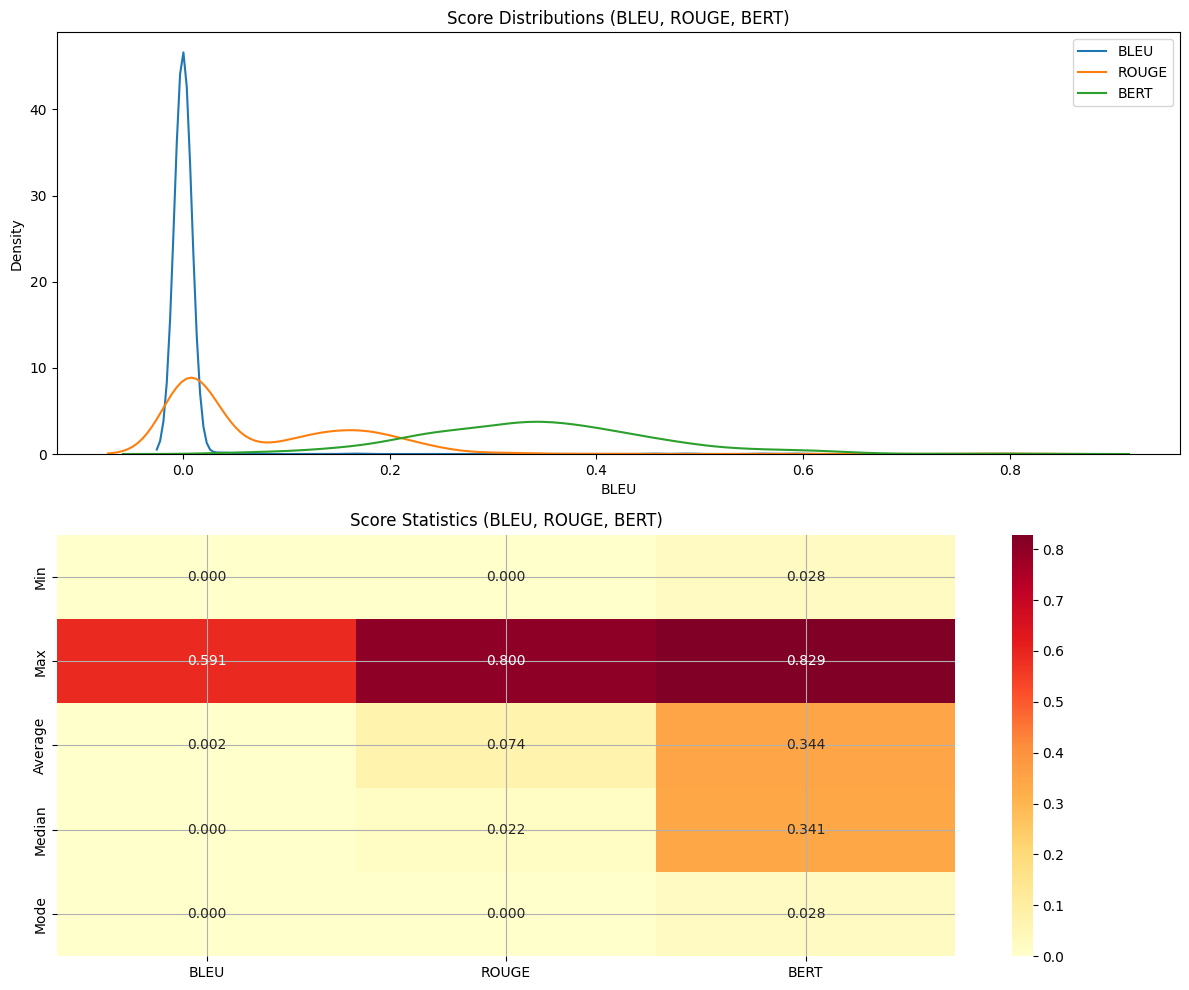

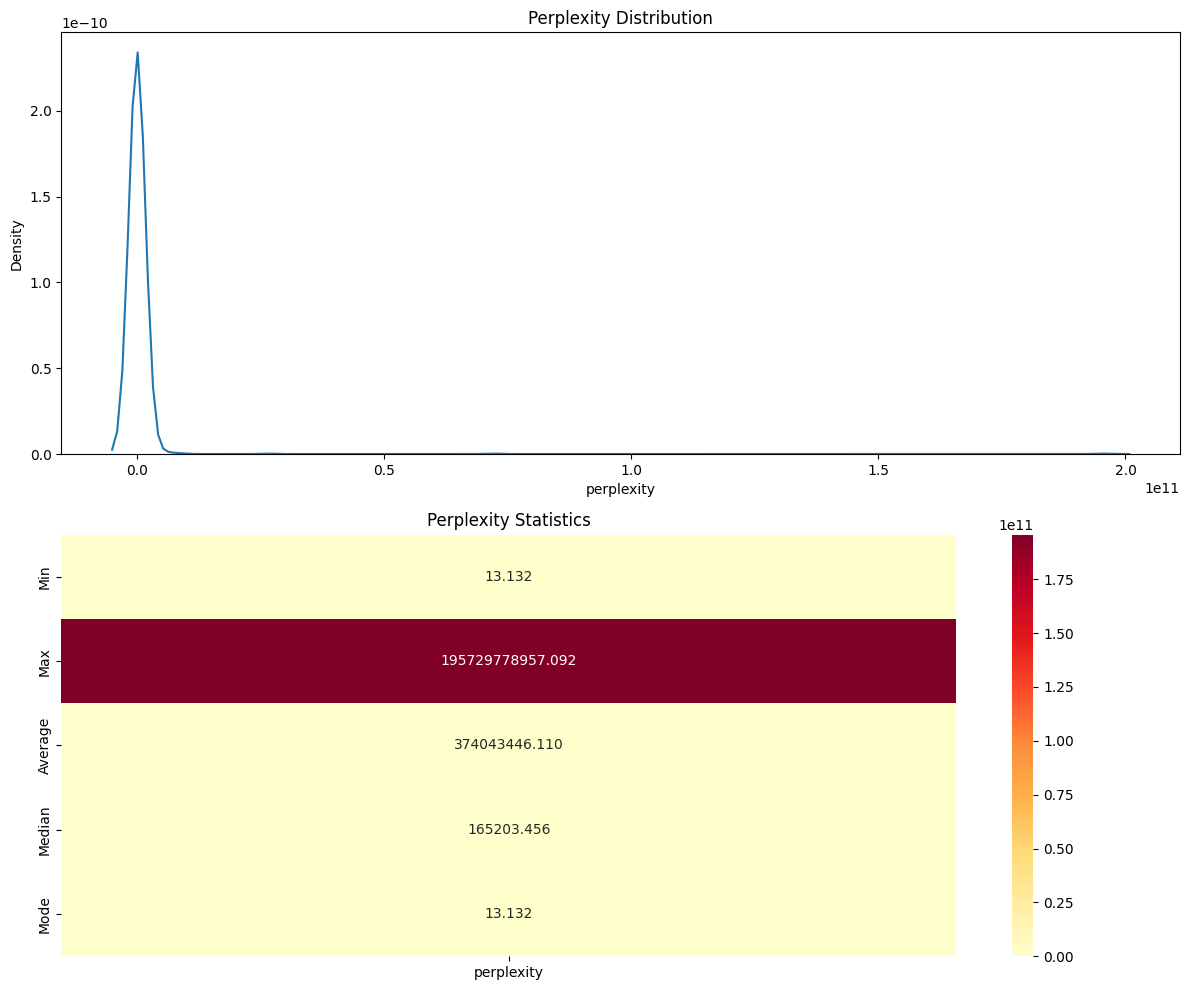

In [8]:

plot_evaluations(dreams_interpretations_df)


### Mistral

In [9]:
from evaluation import evaluate_dream_interpretations
from utils import read_csvs
from summarizer import PromptFormatter
model_family="decoder"

formatter = PromptFormatter(model_family)

In [10]:
dataset = read_csvs(save_dir = output_root + "/Mistral")
dataset["meaning"] = dataset.interpretation.apply(formatter.unformat)
dataset = dataset[["text_dream", "context", "meaning"]]
dataset

,text_dream,context,meaning
0,I dreamed I was at a bus station getting ready...,To dream that you are in a bus accident;Dreami...,The dreamer is feeling helpless and trapped in...
1,I was doing a group meeting or lecture in the ...,"On a spiritual note, this dream;To dream that ...",The dream is about your spiritual growth and y...
2,A patient named Young -- from a former ward --...,To dream that you have been assaulted;To dream...,The dream starts with the appearance of a form...
3,"Bald Hair Cut I'm in a barbershop, which may ...",To dream that someone is giving you a haircut;...,"The dreamer is in a barber shop, which is a sy..."
4,I dreamed that I was in a chemistry laboratory...,To dream that you are in a laboratory;Dreaming...,The dream is about personal growth and learnin...
...,...,...,...
35,A man (feminine-looking) sits on the floor. I ...,To dream that you are giving sweets to a loved...,The dream starts with a feminine-looking man w...
36,Michael J. Fox (who looked like Darryl sometim...,To dream that you (or your mate) have a mistre...,The dream is about your sexuality and intimacy...
37,"Mary and I are in our bedroom. She wakes up, g...","Similarly to food, to dream about soup;If ther...","The dream starts with Mary being sick, which i..."
38,"(07/15/97)[""Lions and a cliff.""] I am travelin...",Dreaming of a dead lion;To see or dream that y...,The dream describes a situation where the drea...


In [11]:
dreams_interpretations_df = evaluate_dream_interpretations(dataset, dream_column="text_dream", interpretation_column = 'meaning')
dreams_interpretations_df.to_csv('datasets/Mistral-7B-Instruct-v0.2_evaluated.csv', index=False)


/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Con

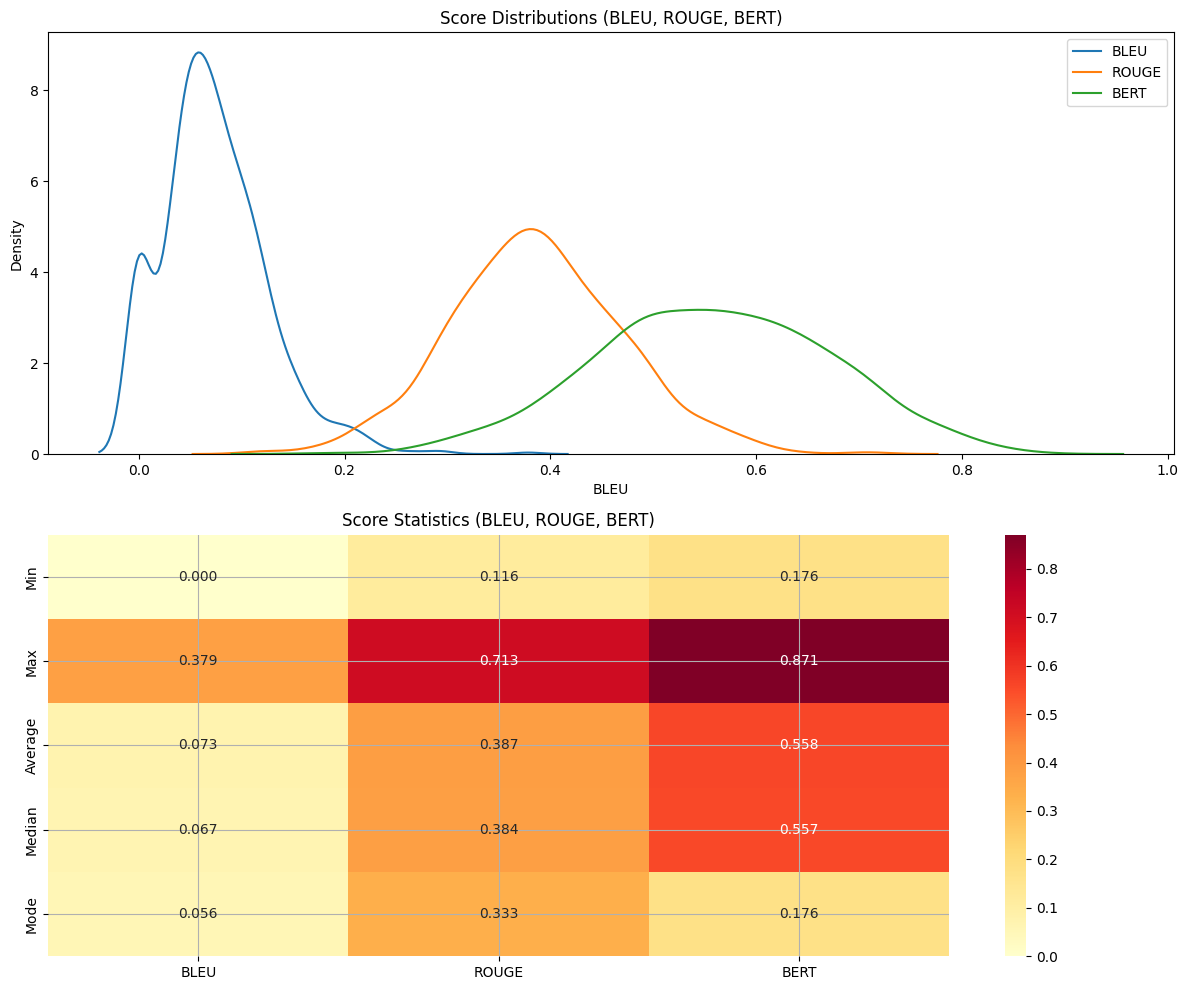

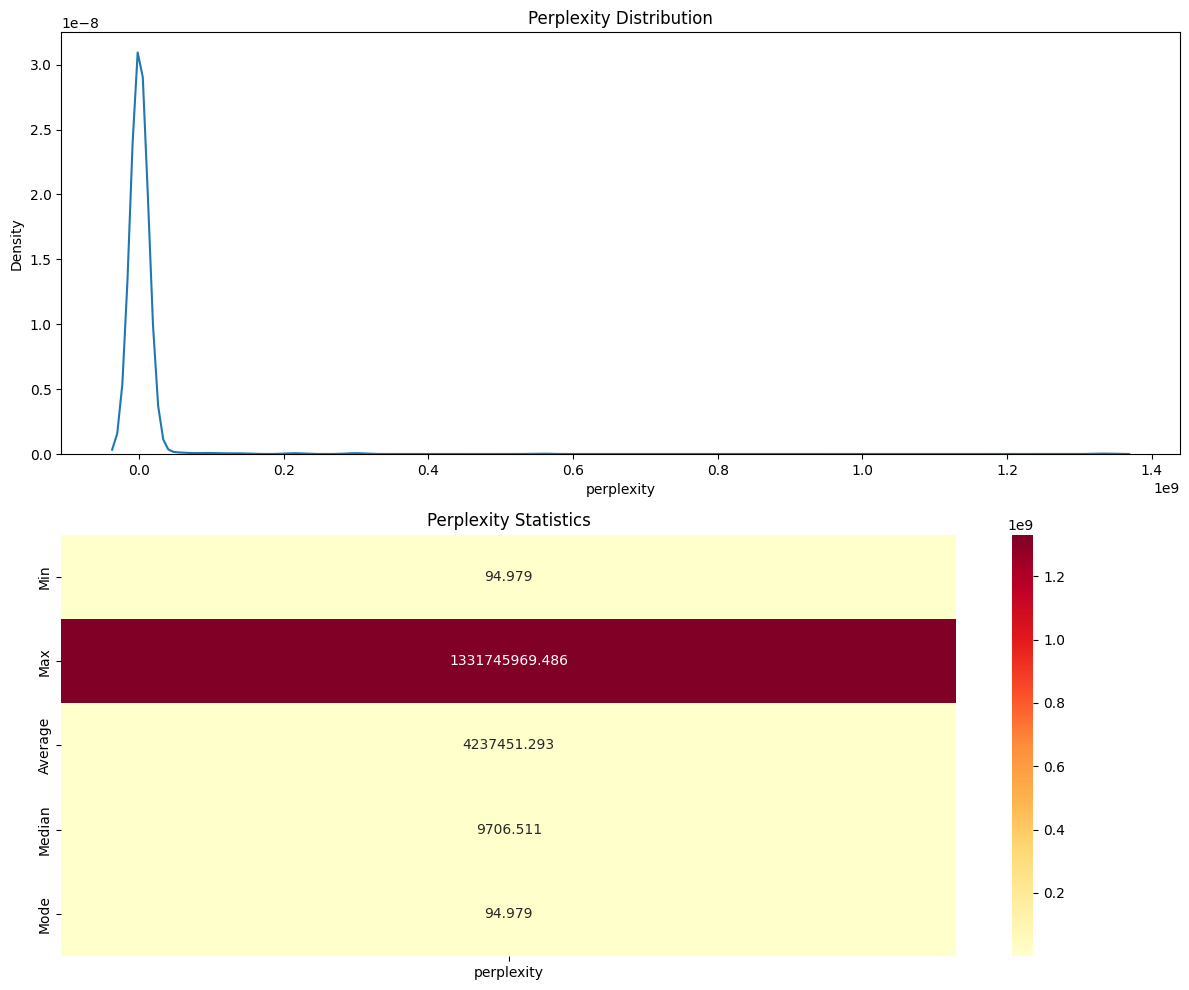

In [12]:
plot_evaluations(dreams_interpretations_df)


We can draw the following conclusions:
1. The bleu score is incredibly low (a good result should be 20-40, we didn't even get 1...). This means that there is a weak overlap between the dream and its interpretation.
2. Same for the Rouge.
3. BERT averages at 0.6, which is not that bad considering that a good value is 0.85–0.9 that indicates some semantic similarity between the dream and its interpretation.
4. perplexity is terrible since a good value is under 20...
5. We interpret the results using this table:


| **Metric** | **High Score Meaning** | **Low Score Meaning** | **Preferred Score** | **Typical Values for Good Results** | **Why?** |
| --- | --- | --- | --- | --- | --- |
| **BLEU** | High n-gram overlap between reference and candidate text | Low n-gram overlap between reference and candidate text | **High** | 20–40 (moderate), 40+ (good) | High BLEU indicates the candidate text closely matches the reference text. |
| **Perplexity** | Candidate text is unpredictable and diverges from reference distribution | Candidate text is predictable, fluent, and aligned with reference distribution | **Low** | < 20 (for good results) | Low perplexity shows that the candidate text is fluent, consistent, and aligned with the reference. |
| **ROUGE** | More overlapping n-grams (e.g., unigrams, bigrams) and higher recall of key phrases | Fewer overlapping n-grams and poor recall of key phrases | **High** | 30–50 (good), 50+ (very good) | High ROUGE suggests greater similarity between the candidate and reference texts. |
| **BERTScore** | Strong semantic similarity between the candidate and reference text | Weak semantic similarity between the candidate and reference text | **High** | 0.85–0.98 (good) | Higher BERTScore reflects that the candidate preserves the meaning of the reference text. |

